In [5]:
%matplotlib inline
import torch
# The torch package contains data structures for multi-dimensional tensors 
# and mathematical operations over these are defined.
from torch import nn
# nn: neural network
from torch.utils import data
# useful tools about process data
from torchvision import datasets, transforms
# built-in datasets and transforms 
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # prevent imshow error

# 1.获取cifar10数据

In [7]:
train_set = datasets.CIFAR10(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_set = datasets.CIFAR10(root='../data', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [8]:
batch_size = 128
train_iter = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# 2. 探索数据

In [9]:
def get_mnist_labels(labels): #@save
    """
    将y的id转化成name
    """
    text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return [text_labels[int(i)] for i in labels]

In [10]:
def show_images(images, num_rows=2, num_columns=5, scale=2, titles=None):
    """
    展示图片
    """
    _, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * scale, num_rows * scale))
    axes = axes.flatten()
    names = get_mnist_labels(titles)
    for i, (ax, img) in enumerate(zip(axes, images)):
        ax.imshow(img.permute(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(names[i])
    plt.show()

In [11]:
len(train_set), len(test_set)

(50000, 10000)

In [12]:
train_set[0][0].shape

torch.Size([3, 32, 32])

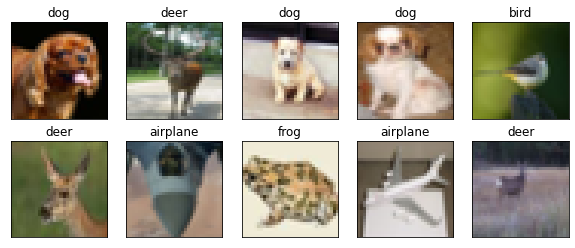

In [13]:
begin = np.random.randint(0, len(train_set) - 10)
show_images([train_set[i + begin][0] for i in range(10)], titles=[train_set[i + begin][1] for i in range(10)])

# 3. 函数

In [14]:
def try_gpu():
    """
    尽量使用gpu
    """
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
class Accumulator:
    """
    For accumulating sums over `n` variables.
    """
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [16]:
def evaluate_accuracy(data_iter, model):
    """
    计算模型的准确性
    model需要在try_gpu()里
    """
    metric = Accumulator(2)
    device = try_gpu()
    model.eval() # 预测模式
    with torch.no_grad(): # 不跟踪grad
        for x, y in data_iter:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            metric.add(torch.sum(torch.argmax(y_pred, dim=1) == y).item(), x.shape[0])
    return metric[0] / metric[1]

In [17]:
def init_weights(m):
    """
    自定义初始化
    使用方法: model.apply(init_weights)
    pytorch有默认初始化，一般不需要
    """
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

In [18]:
def train_images(model, learning_rate, num_epoches, data_iter=train_iter):
    """
    训练模型的函数
    """
    metric = Accumulator(2)
    device = try_gpu()
    model = model.to(device=device) # 模型尽量使用gpu
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epoches):
        model.train() # 训练模式
        metric.reset()
        for x, y in data_iter:
            x, y = x.to(device), y.to(device) # 数据尽量使用gpu
            l = loss(model(x), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            metric.add(l, x.shape[0])
        accuracy = evaluate_accuracy(test_iter, model)
        print(f"epoch {epoch + 1} loss: {metric[0] / metric[1]}, test accuracy: {accuracy}")

In [19]:
def check_shape(model, size):
    """
    查看模型各层的shape
    """
    X = torch.randn(size=size, dtype=torch.float32)
    for layer in model:
        X = layer(X)
        print(layer.__class__.__name__,'output shape: \t',X.shape)

# 4.模型

## 4.1 线性模型

In [20]:
3 * 32 * 32

3072

In [21]:
# !nvidia-smi

In [22]:
linear = nn.Sequential(nn.Flatten(), nn.Linear(3072, 10))

In [23]:
check_shape(linear, size=(1, 3, 32, 32))

Flatten output shape: 	 torch.Size([1, 3072])
Linear output shape: 	 torch.Size([1, 10])


In [24]:
train_images(linear, 0.1, 10)

epoch 1 loss: 0.29833714428424835, test accuracy: 0.3382
epoch 2 loss: 0.17928561986923217, test accuracy: 0.2592
epoch 3 loss: 0.19005355155944825, test accuracy: 0.189
epoch 4 loss: 0.17943695457458497, test accuracy: 0.1985
epoch 5 loss: 0.17543354354858398, test accuracy: 0.2412
epoch 6 loss: 0.17730771717071533, test accuracy: 0.2676
epoch 7 loss: 0.1785336543750763, test accuracy: 0.2885
epoch 8 loss: 0.19142499924659728, test accuracy: 0.302
epoch 9 loss: 0.17259979194641115, test accuracy: 0.2885
epoch 10 loss: 0.17765535335540772, test accuracy: 0.2456


# 4.2 mlp

In [18]:
mlp = nn.Sequential(nn.Flatten(),
                    nn.Linear(3072, 128),
                    nn.ReLU(),
                    nn.Linear(128, 10))

In [19]:
train_fashion_mnist(mlp, 0.1, 10)

epoch 1 loss: 0.012671762776374816, test accuracy: 0.5752
epoch 2 loss: 0.008519252842664719, test accuracy: 0.5718
epoch 3 loss: 0.008254284858703614, test accuracy: 0.5699
epoch 4 loss: 0.00819022106130918, test accuracy: 0.5843
epoch 5 loss: 0.008282070034742356, test accuracy: 0.5868
epoch 6 loss: 0.007807057601213455, test accuracy: 0.6075
epoch 7 loss: 0.008210337934891383, test accuracy: 0.5313
epoch 8 loss: 0.0084876075198253, test accuracy: 0.4914
epoch 9 loss: 0.008520657822489739, test accuracy: 0.6006
epoch 10 loss: 0.008304634024699529, test accuracy: 0.471


# 4.3 cnn

In [80]:
conv_net = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2),
                         nn.ReLU(),
                         nn.MaxPool2d(kernel_size=2, stride=2),
                         nn.Conv2d(8, 16, kernel_size=3, padding=1),
                         nn.ReLU(),
                         nn.MaxPool2d(2, 2),
                         nn.Flatten(),
                         nn.Linear(16 * 8 * 8, 10))

In [81]:
check_shape(conv_net, size=(1, 3, 32, 32))

Conv2d output shape: 	 torch.Size([1, 8, 32, 32])
ReLU output shape: 	 torch.Size([1, 8, 32, 32])
MaxPool2d output shape: 	 torch.Size([1, 8, 16, 16])
Conv2d output shape: 	 torch.Size([1, 16, 16, 16])
ReLU output shape: 	 torch.Size([1, 16, 16, 16])
MaxPool2d output shape: 	 torch.Size([1, 16, 8, 8])
Flatten output shape: 	 torch.Size([1, 1024])
Linear output shape: 	 torch.Size([1, 10])


In [83]:
train_images(conv_net, 0.03, 10)

KeyboardInterrupt: 

# 4.4 vgg

In [84]:
def vgg_block(num_convs, input_channels, output_channels):
    """
    一个具有num_convs个卷积层，输入channels为input_channels,输出channels为output_channels的vgg_block
    """
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        input_channels = output_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [85]:
vgg = nn.Sequential(vgg_block(2, 3, 16),
                    vgg_block(2, 16, 32),
                    nn.Flatten(),
                    nn.Linear(32 * 8 * 8, 256), nn.ReLU(), nn.Dropout(0.5),
                    nn.Linear(256, 10))

In [87]:
check_shape(vgg, size=(1, 3, 32, 32))

Sequential output shape: 	 torch.Size([1, 16, 16, 16])
Sequential output shape: 	 torch.Size([1, 32, 8, 8])
Flatten output shape: 	 torch.Size([1, 2048])
Linear output shape: 	 torch.Size([1, 256])
ReLU output shape: 	 torch.Size([1, 256])
Dropout output shape: 	 torch.Size([1, 256])
Linear output shape: 	 torch.Size([1, 10])


In [89]:
train_images(vgg, 0.01, 5)

KeyboardInterrupt: 

# 4.5 res-net和batch normalization

In [1]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [90]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU()

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.relu(Y)

In [91]:
def resnet_block(input_channels, num_channels, num_residuals):
    blk = []
    for i in range(num_residuals):
        if i == 0:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [92]:
res_net = nn.Sequential(*resnet_block(3, 8, 2),
                        *resnet_block(8, 16, 2),
                        nn.Flatten(),
                        nn.Linear(16 * 8 * 8, 128), nn.ReLU(), nn.Dropout(0.5),
                        nn.Linear(128, 10))

In [94]:
check_shape(res_net, size=(1, 3, 32, 32))

Residual output shape: 	 torch.Size([1, 8, 16, 16])
Residual output shape: 	 torch.Size([1, 8, 16, 16])
Residual output shape: 	 torch.Size([1, 16, 8, 8])
Residual output shape: 	 torch.Size([1, 16, 8, 8])
Flatten output shape: 	 torch.Size([1, 1024])
Linear output shape: 	 torch.Size([1, 128])
ReLU output shape: 	 torch.Size([1, 128])
Dropout output shape: 	 torch.Size([1, 128])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
train_fashion_mnist(res_net, 0.01, 5)